Importamos los paquetes.

In [28]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from numpy.random import uniform

Cargamos los datos necesarios.

In [2]:
demographic = pd.read_csv('../data/national-health-and-nutrition-examination-survey/demographic.csv', sep=',')
diet = pd.read_csv('../data/national-health-and-nutrition-examination-survey/diet.csv', sep=',')
examination = pd.read_csv('../data/national-health-and-nutrition-examination-survey/examination.csv', sep=',')
labs = pd.read_csv('../data/national-health-and-nutrition-examination-survey/labs.csv', sep=',')
medications = pd.read_csv('../data/national-health-and-nutrition-examination-survey/medications.csv', sep=',', 
                          encoding='iso-8859-1')
questionnaire = pd.read_csv('../data/national-health-and-nutrition-examination-survey/questionnaire.csv', sep=',')

Realizamos una limpieza de los datos de medications. Nos quedamos solo con los que sean no nulos.
Agrupamos por SEQN tras descategorizar, ya que en medications aparece más de un registro por paciente, debido a que un paciente puede haber sido tratado por más de un motivo.

Para ello creamos un registro por paciente que tenga como variable cada una de las
enfermedades del conjunto de datos como variable binarizada. Seleccionamos solo las variables de interés. 

Convertimos el nombre de las columnas de medications2 a lista para poder tenerlas identificadas y poder tratarlas después.

In [3]:
medications = medications[medications.RXDRSD1.notnull()]

medications2 = pd.get_dummies(medications[['SEQN', 'RXDRSC1']]).groupby(['SEQN']).sum()
for i in medications2.columns:
    medications2.loc[medications2[i] > 1, i] = 1

medications2=medications2.reset_index()
# medications2
    
variablesMedications = medications2.columns.to_list()

Unimos los archivos.

In [4]:
df = pd.merge(demographic, examination, how='outer', on='SEQN')
# df
df = pd.merge(df, diet, how='outer', on='SEQN')
# df
df = pd.merge(df, labs, how='outer', on='SEQN')
# df
df = pd.merge(df, questionnaire, how='outer', on='SEQN')
# df
df = pd.merge(df, medications2, how='inner', on='SEQN')

Realizamos una selección de variables del dataframe. Estas variables son escogidas por estar relacionadas con los factores de riesgos de la hipertensión.

In [5]:
variables = [ 'ALQ101', 'ALQ110', 'ALQ120Q', 'ALQ130', 'ALQ141Q', 'ALQ151', 'ALQ160', 'BMDBMIC', 'BMIWAIST', 'RIDEXAGM',
             'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ060', 'BPQ070', 'BPQ080', 'BPQ090D', 'CBD070', 'CBD090', 'CBD110',
             'CBD120', 'CBD130', 'DBD100', 'DBQ095Z', 'DID040', 'DID060', 'DID260', 'DID320', 'DID330', 'DIQ010', 'DIQ050', 
             'DIQ070', 'DIQ080', 'DIQ170', 'DIQ172', 'DIQ175A', 'DIQ175B', 'DIQ175C', 'DIQ175D', 'DIQ175E', 'DIQ175F', 
             'DIQ175G', 'DIQ175H', 'DIQ175I', 'DIQ175J', 'DIQ175K', 'DIQ175L', 'DIQ175M', 'DIQ175N', 'DIQ175O', 'DIQ175P',
             'DIQ175Q', 'DIQ175R', 'DIQ175S', 'DIQ175T', 'DIQ175U', 'DIQ175V', 'DIQ175W', 'DIQ175X', 'DIQ180', 'DIQ230', 
             'DIQ240', 'DIQ260U', 'DIQ275', 'DIQ280', 'DIQ291', 'DMDHREDU', 'DMDHSEDU', 'DR1.300', 'DR1.320Z', 'DR1.330Z',
             'DR1BWATZ', 'DR1DAY', 'DR1SKY', 'DR1STY', 'DR1TACAR', 'DR1TALCO', 'DR1TATOA', 'DR1TATOC', 'DR1TB12A', 
             'DR1TBCAR', 'DR1TCAFF', 'DR1TCALC', 'DR1TCARB', 'DR1TCHL', 'DR1TCHOL', 'DR1TCOPP', 'DR1TCRYP', 'DR1TFA',
             'DR1TFDFE', 'DR1TFF', 'DR1TFIBE', 'DR1TFOLA', 'DR1TIRON', 'DR1TKCAL', 'DR1TLYCO', 'DR1TLZ', 'DR1TM161',
             'DR1TM181', 'DR1TM201', 'DR1TM221', 'DR1TMAGN', 'DR1TMFAT', 'DR1TMOIS', 'DR1TNIAC', 'DR1TNUMF', 'DR1TP182', 
             'DR1TP183', 'DR1TP184', 'DR1TP204', 'DR1TP205', 'DR1TP225', 'DR1TP226', 'DR1TPFAT', 'DR1TPHOS', 'DR1TPOTA',
             'DR1TPROT', 'DR1TRET', 'DR1TS040', 'DR1TS060', 'DR1TS080', 'DR1TS100', 'DR1TS120', 'DR1TS140', 'DR1TS160', 
             'DR1TS180', 'DR1TSELE', 'DR1TSFAT', 'DR1TSODI', 'DR1TSUGR', 'DR1TTFAT', 'DR1TTHEO', 'DR1TVARA', 'DR1TVB1', 
             'DR1TVB12', 'DR1TVB2', 'DR1TVB6', 'DR1TVC', 'DR1TVD', 'DR1TVK', 'DR1TWS', 'DR1TZINC', 'DRD340', 'DRD350A', 
             'DRD350AQ', 'DRD350B', 'DRD350BQ', 'DRD350C', 'DRD350CQ', 'DRD350D', 'DRD350DQ', 'DRD350E', 'DRD350EQ',
             'DRD350F', 'DRD350FQ', 'DRD350G', 'DRD350GQ', 'DRD350H', 'DRD350HQ', 'DRD350I', 'DRD350IQ', 'DRD350J',
             'DRD350JQ', 'DRD350K', 'DRD360', 'DRD370A', 'DRD370AQ', 'DRD370B', 'DRD370BQ', 'DRD370C', 'DRD370CQ',
             'DRD370D', 'DRD370DQ', 'DRD370E', 'DRD370EQ', 'DRD370F', 'DRD370FQ', 'DRD370G', 'DRD370GQ', 'DRD370H',
             'DRD370HQ', 'DRD370I', 'DRD370IQ', 'DRD370J', 'DRD370Q', 'DRD370K', 'DRD370KQ', 'DRD370L', 'DRD370LQ',
             'DRD370M', 'DRD370MQ', 'DRD370N', 'DRD370NQ', 'DRD370O', 'DRD370OQ', 'DRD370P', 'DRD370PQ', 
             'DRD370QQ', 'DRD370R', 'DRD370RQ', 'DRD370S', 'DRD370SQ', 'DRD370T', 'DRD370TQ', 'DRD370U', 'DRD370UQ', 
             'DRD370V', 'DRQSDIET', 'DRQSDT1', 'DRQSDT10', 'DRQSDT11', 'DRQSDT12', 'DRQSDT2', 'DRQSDT3', 'DRQSDT4',
             'DRQSDT5', 'DRQSDT6', 'DRQSDT7', 'DRQSDT8', 'DRQSDT9', 'DRQSDT91', 'DRQSPREP', 'FSD012N', 'FSD032A', 
             'FSD032B', 'FSD032D', 'FSD032E', 'FSD032F', 'FSD041', 'FSD061', 'FSD081', 'FSD092', 'FSD102', 'FSD111', 
             'FSD122', 'FSD141', 'FSD146', 'FSD151', 'FSD225', 'FSD230', 'FSD650ZC', 'FSD650ZW', 'FSD660ZC', 'FSD660ZW',
             'FSD670ZC', 'FSD670ZW', 'FSD675', 'FSD680', 'FSQ012', 'FSQ235', 'FSQ690', 'FSQ695', 'HIQ011', 'HIQ031A',
             'HIQ031AA', 'HIQ031B', 'HIQ031C', 'HIQ031D', 'HIQ031E', 'HIQ031F', 'HIQ031G', 'HIQ031H', 'HIQ031I', 'HIQ031J',
             'HIQ105', 'HIQ210', 'HIQ260', 'HIQ270', 'HOD050', 'HOQ065', 'IND235', 'IND247', 'INDFMMPC', 'INDFMMPI', 
             'INDFMPIR', 'INQ140', 'INQ150', 'INQ244', 'LBDHDD', 'LBDHDDSI', 'LBDLDL', 'LBDLDLSI', 'LBDSCHSI', 'LBDTCSI', 
             'LBXSCH', 'LBXTC', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ180B', 'MCQ180C', 'MCQ180D',
             'MCQ180E', 'MCQ180F', 'MCQ240J', 'MCQ300A', 'MCQ300C', 'MCQ365A', 'MCQ365B', 'MCQ365C', 'MCQ365D', 'MCQ370A', 
             'MCQ370B', 'MCQ370C', 'MCQ370D', 'OHQ610', 'PAQ605', 'PAQ610', 'PAQ620', 'PAQ625', 'PAQ635', 'PAQ640', 'PAQ650',
             'PAQ655', 'PAQ665', 'PAQ670', 'PAQ677', 'PAQ678', 'PAQ679', 'PAQ706', 'PAQ710', 'PAQ715', 'PAQ722', 'PAQ724A',
             'PAQ724AA', 'PAQ724AB', 'PAQ724AC', 'PAQ724AD', 'PAQ724AE', 'PAQ724AF', 'PAQ724B', 'PAQ724C', 'PAQ724CM', 
             'PAQ724D', 'PAQ724E', 'PAQ724F', 'PAQ724G', 'PAQ724H', 'PAQ724I', 'PAQ724J', 'PAQ724K', 'PAQ724L', 'PAQ724M', 
             'PAQ724N', 'PAQ724O', 'PAQ724P', 'PAQ724Q', 'PAQ724R', 'PAQ724S', 'PAQ724T', 'PAQ724U', 'PAQ724V', 'PAQ724W',
             'PAQ724X', 'PAQ724Y', 'PAQ724Z', 'PAQ731', 'PAQ740', 'PAQ742', 'PAQ744', 'PAQ746', 'PAQ748', 'PAQ750', 'PAQ755',
             'PAQ759A', 'PAQ759B', 'PAQ759C', 'PAQ759D', 'PAQ759E', 'PAQ759F', 'PAQ759G', 'PAQ759H', 'PAQ759I', 'PAQ759J',
             'PAQ759K', 'PAQ759L', 'PAQ759M', 'PAQ759N', 'PAQ759O', 'PAQ759P', 'PAQ759Q', 'PAQ759R', 'PAQ759S', 'PAQ759T',
             'PAQ759U', 'PAQ759V', 'PAQ762', 'PAQ764', 'PAQ766', 'PAQ770', 'PAQ772A', 'PAQ772B', 'PAQ772C', 'PFQ020', 
             'PFQ030', 'PFQ033', 'PFQ041', 'PFQ049', 'PFQ051', 'PFQ054', 'PFQ057', 'PFQ059', 'PFQ061A', 'PFQ061B', 'PFQ061C',
             'PFQ061D', 'PFQ061E', 'PFQ061F', 'PFQ061G', 'PFQ061H', 'PFQ061I', 'PFQ061J', 'PFQ061K', 'PFQ061L', 'PFQ061M', 
             'PFQ061N', 'PFQ061O', 'PFQ061P', 'PFQ061Q', 'PFQ061R', 'PFQ061S', 'PFQ061T', 'PFQ063A', 'PFQ063B', 'PFQ063C', 
             'PFQ063D', 'PFQ063E', 'PFQ090', 'PHAALCHR', 'PHAALCMN', 'PHQ030', 'RHQ162', 'RHQ163', 'RIAGENDR', 'RIDAGEMN',
             'RIDAGEYR', 'RIDRETH1', 'RIDRETH3', 'RXQ510', 'RXQ520', 'SMD030', 'SMD055', 'SMD093', 'SMD100BR', 
             'SMD100CO', 'SMD100FL', 'SMD100LN', 'SMD100MN', 'SMD100NI', 'SMD100TR', 'SMD460', 'SMD470', 'SMD630', 'SMD641',
             'SMD650', 'SMDANY', 'SMDUPCA', 'SMQ020', 'SMQ040', 'SMQ050Q', 'SMQ078', 'SMQ621', 'SMQ661', 'SMQ665A',
             'SMQ665B', 'SMQ665C', 'SMQ665D', 'SMQ670', 'SMQ681', 'SMQ690A', 'SMQ690B', 'SMQ690C', 'SMQ690D', 'SMQ690E', 
             'SMQ690F', 'SMQ690G', 'SMQ690H', 'SMQ690I', 'SMQ690J', 'SMQ710', 'SMQ720', 'SMQ725', 'SMQ740', 'SMQ770',
             'SMQ800', 'SMQ817', 'SMQ830', 'SMQ840', 'SMQ845', 'SMQ848', 'SMQ849', 'SMQ851', 'SMQ852Q', 'SMQ852U', 'SMQ856',
             'SMQ857', 'SMQ858', 'SMQ860', 'SMQ861', 'SMQ862', 'SMQ863', 'SMQ866', 'SMQ868', 'SMQ870', 'SMQ872', 'SMQ874',
             'SMQ876', 'SMQ878', 'SMQ880']


In [6]:
variables = variables + variablesMedications
data = df[variables]

Imputamos los Nan.


Se eliminan las filas y columnas que tengan todos los elementos nulos

In [7]:
data.dropna(axis=0, how='all', inplace=True)
data.dropna(axis=1, how='all', inplace=True)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Imputamos RIDAGEMN. Esta variable es la edad en meses y en pacientes mayores de 2 años no aparece este dato. 
Es una posible variable de interés para poder tener una edad más exacta.
Así que en los registros que no existan, multiplicamos la edad en años, RIDAGEYR, por 12 para obtener los meses.

In [8]:
data.RIDAGEMN = data.RIDAGEMN.replace(np.nan, data.RIDAGEYR*12)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Imputamos RIDEXAGM. Esta variable es la edad en meses en el momento del examen. Si el valor es nulo, 
lo imputamos con el valor de RIDAGEMN.

In [9]:
data.RIDEXAGM = data.RIDEXAGM.replace(np.nan, data.RIDAGEMN)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Imputamos de nan de variablesMedications como el valor que más se repite.

In [10]:
for v in variablesMedications:
    if data[v].isnull().sum() != 0:
        data[v].fillna(value=data[v].value_counts().index[0], inplace=True)

Para el resto de valores, hacemos distinción entre si la variable es numérica o categórica, para imputar por la media o por el valor más repetido repectivamente.

In [11]:
#Imputación de nan para el resto
for column in data.columns:
    if data[column].isnull().sum() != 0:
        if data[column].dtype==object:
            data[column].fillna(value=data[column].value_counts().index[0], inplace =True)
        else:
            data[column].fillna(data[column].median(),inplace =True)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Hallamos la matriz de correlación.

In [12]:
matrizCorrelacion = data.corr()

Sacamos las variables que están relacionadas como aquellas cuya correlación sea mayor o igual a 0.8

In [14]:
variablesCorreladas = list()
for i in range(len(matrizCorrelacion)):
    var1 = matrizCorrelacion.columns[i]
    for j in range(len(matrizCorrelacion)):
        var2 = matrizCorrelacion.columns[j]
        elemento = matrizCorrelacion.iloc[i,j]
        if (i<j) & (abs(elemento) >= 0.8):
            l = list()
            l.append([var1, var2])
            l.append(elemento)
            variablesCorreladas.append(l)
variablesCorreladas

[[['RIDEXAGM', 'RIDAGEMN'], 0.9999710894656363],
 [['RIDEXAGM', 'RIDAGEYR'], 0.9999710262472322],
 [['BMXBMI', 'BMXWAIST'], 0.8675863340983514],
 [['BMXBMI', 'BMXWT'], 0.8476111025441124],
 [['BMXWAIST', 'BMXWT'], 0.8289945865634065],
 [['CBD070', 'CBD090'], 0.929024878355],
 [['DR1TCARB', 'DR1TKCAL'], 0.8836201252562111],
 [['DR1TCARB', 'DR1TSUGR'], 0.8565457786093096],
 [['DR1TCHL', 'DR1TCHOL'], 0.88030065049964],
 [['DR1TCHL', 'DR1TP204'], 0.8081693839519434],
 [['DR1TCHL', 'DR1TPROT'], 0.8167025100470946],
 [['DR1TCHOL', 'DR1TP204'], 0.9071426818854488],
 [['DR1TFA', 'DR1TFDFE'], 0.9166653459610049],
 [['DR1TFA', 'DR1TFOLA'], 0.8163829812334826],
 [['DR1TFDFE', 'DR1TFOLA'], 0.9791433034841055],
 [['DR1TKCAL', 'DR1TM181'], 0.8343841514527328],
 [['DR1TKCAL', 'DR1TMFAT'], 0.8476812620318654],
 [['DR1TKCAL', 'DR1TPHOS'], 0.8422369669551835],
 [['DR1TKCAL', 'DR1TS160'], 0.8561690179377299],
 [['DR1TKCAL', 'DR1TS180'], 0.8305754785131776],
 [['DR1TKCAL', 'DR1TSFAT'], 0.8346930382794032]

Eliminamos las variables que están relacionadas, excepto si son enfermedades.

In [15]:
for i in variablesCorreladas:
    if (i[0][1] in data.columns) & (i[0][1] not in variablesMedications):
        data.drop([i[0][1]], axis = 1, inplace=True)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Convertimos las variables categóricas a numéricas.

In [16]:
data = pd.get_dummies(data)

Definimos los pacientes que no sean hipertensivos como 0 y los que si lo son como 1. La hipertensión está diagnosticada dentro de la variable RXDRSC1_I10

In [17]:
data.rename(columns={'RXDRSC1_I10':'is_hypertensive'}, inplace=True)

In [18]:
X = data.drop(['is_hypertensive'], axis=1)
y = data.is_hypertensive

Normalizamos los datos con StandardScaler()

In [19]:
scaler = StandardScaler()
XN = scaler.fit_transform(X)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [20]:
XN = pd.DataFrame(data=XN, columns=X.columns)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(XN, y, test_size=1/3, random_state=158)

Definimos la función para que nos muestre la matriz de confusión gráficamente.

In [22]:
def matrizConfusion(Ytest, prediccion):
    matrizConf = confusion_matrix(Ytest, prediccion)
    fig, ax = plot_confusion_matrix(conf_mat=matrizConf)
plt.show()

Definimos una función que nos devuelva el valor de los verdaderos y falsos positivos y negativos.

In [23]:
def matrizConfusionValores(YTest, prediccion):
    m = confusion_matrix(YTest, prediccion)
    TN = m[0][0]
    TP = m[1][1]
    FP = m[0][1]
    FN = m[1][0]
    return [TN, TP, FP, FN]

#     print('Verdaderos Positivos: {}'.format(TP))
#     print('Verdaderos Negativos: {}'.format(TN))
#     print('Falsos Positivos: {}'.format(FP))
#     print('Falsos Negativos: {}'.format(FN))

Definimos una función que nos devuelvan las métricas derivadas de la matriz de confusión.

In [24]:
def metricas(lista):
    ACC = (lista[0] + lista[1])/(lista[0] + lista[1] + lista[2] + lista[3])
    ERR = ACC - 1
    TPR = lista[1]/(lista[1] + lista[3])
    #TPR = SEN (sensibilidad) = REC (recall=recuperacion)
    FPR = lista[2]/(lista[0] + lista[2])
    PRE = lista[1]/(lista[1] + lista[2])
    SPE = 1 - FPR
    F1 = (2* PRE * TPR)/(PRE + TPR)
    
    print('Accuracy: {}'.format(ACC*100))
    print('Misclassification error: {}'.format(ERR*100))
    print('True Positive Rate/Recall/Sensitivity: {}'.format(TPR*100))
    print('False Positive Rate: {}'.format(FPR*100))
    print('Precision: {}'.format(PRE*100))  
    print('Specificity: {}'.format(SPE*100))
    print('F1 score: {}'.format(F1*100))   

## SVC

In [ ]:
# class sklearn.svm.SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False,
#                       tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1,
#                       decision_function_shape=’ovr’, random_state=None

RandomizedSearchCV

In [25]:
parametrosSVCRS = {'C': uniform(1, 200, 5), 'gamma': uniform(0.001, 100, 5)}
SVC = SVC()

SVCRS = RandomizedSearchCV(SVC, param_distributions = parametrosSVCRS, cv = 10)

SVCRS.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': array([ 97.2526 ,  63.05337, 169.33773,  64.77929, 125.92643]), 'gamma': array([38.80504, 61.83093, 40.41545, 11.86048, 99.44276])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [26]:
print('Valor óptimo para C: {}'.format(SVCRS.best_params_['C']))
print('Valor óptimo para gamma: {}'.format(SVCRS.best_params_['gamma']))

Valor óptimo para C: 63.05336956184319
Valor óptimo para gamma: 99.4427624643569


In [29]:
SVCRSBest = SVC(C=SVCRS.best_params_['C'], gamma=SVCRS.best_params_['gamma'])
SVCRSBest.fit(X_train, y_train)

predsSVCRS = SVCRSBest.predict(X_test)

accuracySVCRS = np.true_divide(np.sum(predsSVCRS == y_test), predsSVCRS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracySVCRS))

Precisión en el conjunto de test: 58.25%


GridSearchCV

In [30]:
parametrosSVCGD = {'C': [25, 39, 65], 'gamma': [20, 99, 100]}
SVCGB = GridSearchCV(SVC(), param_grid=parametrosSVCGD, cv=10)
SVCGB.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [25, 39, 65], 'gamma': [20, 99, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
means = SVCGB.cv_results_['mean_test_score']
stds = SVCGB.cv_results_['std_test_score']
params = SVCGB.cv_results_['params']
ranks = SVCGB.cv_results_['rank_test_score']

In [32]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 25, 'gamma': 20}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 25, 'gamma': 99}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 25, 'gamma': 100}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 39, 'gamma': 20}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 39, 'gamma': 99}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 39, 'gamma': 100}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 65, 'gamma': 20}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 65, 'gamma': 99}
1) Precisión media: 61.30 +/- 0.11 con parámetros {'C': 65, 'gamma': 100}


In [33]:
print('Valor óptimo para C: {}'.format(SVCGB.best_params_['C']))
print('Valor óptimo para gamma: {}'.format(SVCGB.best_params_['gamma']))

Valor óptimo para C: 25
Valor óptimo para gamma: 20


In [34]:
SVCBestGS = SVC(C=SVCGB.best_params_['C'], gamma=SVCGB.best_params_['gamma'])
SVCBestGS.fit(X_train, y_train)

predsSVCGS = SVCBestGS.predict(X_test)

accuracy = np.true_divide(np.sum(predsSVCGS == y_test), predsSVCGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracy))

Precisión en el conjunto de test: 58.25%


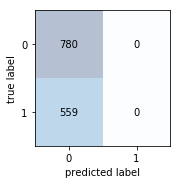

In [35]:
matrizConfusion(y_test, predsSVCGS)  

In [36]:
m = matrizConfusionValores(y_test, predsSVCGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 780
Verdaderos Positivos: 0
Falsos Positivos: 0
Falsos Negativos: 559


Accuracy: 58.252427184466015
Misclassification error: -41.747572815533985
True Positive Rate/Recall/Sensitivity: 0.0
False Positive Rate: 0.0
Precision: nan
Specificity: 100.0
F1 score: nan


C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


## GradientBoostingClassifier

In [ ]:
# GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, subsample=1.0, criterion=’friedman_mse’,
# min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
# min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None,
# warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001

RandomizedSearchCV

In [37]:
parametrosGBRS = {'learning_rate': uniform(0.01, 1, 50), 'n_estimators': range(50, 150)}
gbc = GradientBoostingClassifier()

GBRS = RandomizedSearchCV(gbc, param_distributions = parametrosGBRS, cv = 10)

GBRS.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'learning_rate': array([0.76466, 0.07261, 0.03582, 0.88721, 0.04233, 0.96465, 0.61764,
       0.08911, 0.8571 , 0.53203, 0.22324, 0.89931, 0.8476 , 0.38937,
       0.45862, 0.19273, 0.97014, 0.84465, 0.51377, 0.8228 , 0.62081,
       0.12915, 0.47874, 0.60191, 0.30668, 0.76327, ...4361, 0.66821, 0.05643, 0.65847, 0.60753, 0.62752,
       0.49188]), 'n_estimators': range(50, 150)},
          pre_dispatch='2*n_jobs', random_state=

In [38]:
print('Valor óptimo para learning_rate: {}'.format(GBRS.best_params_['learning_rate']))
print('Valor óptimo para n_estimators: {}'.format(GBRS.best_params_['n_estimators']))

Valor óptimo para learning_rate: 0.13202878668782944
Valor óptimo para n_estimators: 102


In [39]:
GBRSBest = GradientBoostingClassifier(learning_rate=GBRS.best_params_['learning_rate'], 
                                     n_estimators=GBRS.best_params_['n_estimators'])
GBRSBest.fit(X_train, y_train)

predsGBRS = GBRSBest.predict(X_test)

accuracyGBRS = np.true_divide(np.sum(predsGBRS==y_test), predsGBRS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyGBRS))

Precisión en el conjunto de test: 76.77%


GridSearchCV

In [40]:
parametrosGBGD = {'learning_rate': [0.084, 0.1, 0.13, 0.2], 'n_estimators': [96, 102, 110]}
GBGS = GridSearchCV(GradientBoostingClassifier(), param_grid=parametrosGBGD, cv=10)
GBGS.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.084, 0.1, 0.13, 0.2], 'n_estimators': [96, 102, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
means = GBGS.cv_results_['mean_test_score']
stds = GBGS.cv_results_['std_test_score']
params = GBGS.cv_results_['params']
ranks = GBGS.cv_results_['rank_test_score']

In [42]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

9) Precisión media: 78.07 +/- 2.63 con parámetros {'learning_rate': 0.084, 'n_estimators': 96}
11) Precisión media: 77.89 +/- 2.45 con parámetros {'learning_rate': 0.084, 'n_estimators': 102}
7) Precisión media: 78.30 +/- 2.24 con parámetros {'learning_rate': 0.084, 'n_estimators': 110}
2) Precisión media: 78.67 +/- 2.36 con parámetros {'learning_rate': 0.1, 'n_estimators': 96}
1) Precisión media: 78.71 +/- 2.08 con parámetros {'learning_rate': 0.1, 'n_estimators': 102}
4) Precisión media: 78.56 +/- 2.25 con parámetros {'learning_rate': 0.1, 'n_estimators': 110}
5) Precisión media: 78.41 +/- 2.29 con parámetros {'learning_rate': 0.13, 'n_estimators': 96}
3) Precisión media: 78.63 +/- 2.45 con parámetros {'learning_rate': 0.13, 'n_estimators': 102}
8) Precisión media: 78.18 +/- 2.44 con parámetros {'learning_rate': 0.13, 'n_estimators': 110}
6) Precisión media: 78.33 +/- 2.09 con parámetros {'learning_rate': 0.2, 'n_estimators': 96}
10) Precisión media: 77.96 +/- 2.21 con parámetros {'l

In [43]:
print('Valor óptimo para learning_rate: {}'.format(GBGS.best_params_['learning_rate']))
print('Valor óptimo para n_estimators: {}'.format(GBGS.best_params_['n_estimators']))

Valor óptimo para learning_rate: 0.1
Valor óptimo para n_estimators: 102


In [44]:
GBGSBest = GradientBoostingClassifier(learning_rate=GBGS.best_params_['learning_rate'],
                                          n_estimators=GBGS.best_params_['n_estimators'])
GBGSBest.fit(X_train, y_train)

predsGBGS = GBGSBest.predict(X_test)

accuracyGBGS = np.true_divide(np.sum(predsGBGS==y_test), predsGBGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyGBGS))

Precisión en el conjunto de test: 75.95%


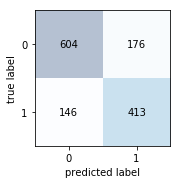

In [45]:
matrizConfusion(y_test, predsGBGS)

In [46]:
m = matrizConfusionValores(y_test, predsGBGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 604
Verdaderos Positivos: 413
Falsos Positivos: 176
Falsos Negativos: 146


Accuracy: 75.95220313666916
Misclassification error: -24.047796863330838
True Positive Rate/Recall/Sensitivity: 73.8819320214669
False Positive Rate: 22.564102564102566
Precision: 70.11884550084889
Specificity: 77.43589743589745
F1 score: 71.95121951219512


## AdaBoost

In [ ]:
# sklearn.ensemble.AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm=’SAMME.R’, 
#                                     random_state=None)

RandomizedSearchCV

In [47]:
parametrosABCRS = {'learning_rate': uniform(0.01, 1, 20), 'n_estimators': range(100, 150)}

ABC = AdaBoostClassifier()
ABCRS = RandomizedSearchCV(ABC, param_distributions = parametrosABCRS, cv = 10)

ABCRS.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'learning_rate': array([0.64819, 0.02881, 0.43807, 0.72977, 0.40701, 0.41179, 0.50226,
       0.24531, 0.61311, 0.83766, 0.07832, 0.91789, 0.39522, 0.81205,
       0.90654, 0.07253, 0.14977, 0.30458, 0.1863 , 0.83024]), 'n_estimators': range(100, 150)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [48]:
print('Valor óptimo para learning_rate: {}'.format(ABCRS.best_params_['learning_rate']))
print('Valor óptimo para n_estimators: {}'.format(ABCRS.best_params_['n_estimators']))

Valor óptimo para learning_rate: 0.3045845799320987
Valor óptimo para n_estimators: 114


In [49]:
ABCRSBest = AdaBoostClassifier(learning_rate=ABCRS.best_params_['learning_rate'], 
                                       n_estimators=ABCRS.best_params_['n_estimators'])
ABCRSBest.fit(X_train, y_train)

predsABCRSBest = ABCRSBest.predict(X_test)

accuracyABCRS = np.true_divide(np.sum(predsABCRSBest == y_test), predsABCRSBest.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyABCRS))

Precisión en el conjunto de test: 76.10%


GridSearchCV

In [50]:
parametrosABCGS = {'learning_rate': [0.05, 0.14, 0.19, 0.3], 'n_estimators': [107, 114, 121]}
ABCGS = GridSearchCV(AdaBoostClassifier(), param_grid=parametrosABCGS, cv=10)
ABCGS.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.14, 0.19, 0.3], 'n_estimators': [107, 114, 121]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
means = ABCGS.cv_results_['mean_test_score']
stds = ABCGS.cv_results_['std_test_score']
params = ABCGS.cv_results_['params']
ranks = ABCGS.cv_results_['rank_test_score']

In [52]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

10) Precisión media: 78.18 +/- 2.02 con parámetros {'learning_rate': 0.05, 'n_estimators': 107}
11) Precisión media: 78.15 +/- 2.15 con parámetros {'learning_rate': 0.05, 'n_estimators': 114}
12) Precisión media: 78.07 +/- 2.17 con parámetros {'learning_rate': 0.05, 'n_estimators': 121}
2) Precisión media: 78.82 +/- 2.47 con parámetros {'learning_rate': 0.14, 'n_estimators': 107}
6) Precisión media: 78.67 +/- 2.48 con parámetros {'learning_rate': 0.14, 'n_estimators': 114}
7) Precisión media: 78.60 +/- 2.68 con parámetros {'learning_rate': 0.14, 'n_estimators': 121}
9) Precisión media: 78.52 +/- 2.53 con parámetros {'learning_rate': 0.19, 'n_estimators': 107}
3) Precisión media: 78.74 +/- 2.40 con parámetros {'learning_rate': 0.19, 'n_estimators': 114}
3) Precisión media: 78.74 +/- 2.62 con parámetros {'learning_rate': 0.19, 'n_estimators': 121}
1) Precisión media: 79.16 +/- 2.45 con parámetros {'learning_rate': 0.3, 'n_estimators': 107}
3) Precisión media: 78.74 +/- 2.68 con parámetro

In [53]:
print('Valor óptimo para learning_rate: {}'.format(ABCGS.best_params_['learning_rate']))
print('Valor óptimo para n_estimators: {}'.format(ABCGS.best_params_['n_estimators']))

Valor óptimo para learning_rate: 0.3
Valor óptimo para n_estimators: 107


In [54]:
ABCGSBest = AdaBoostClassifier(learning_rate=ABCGS.best_params_['learning_rate'],
                               n_estimators=ABCGS.best_params_['n_estimators'])
ABCGSBest.fit(X_train, y_train)

predsABCGS = ABCGSBest.predict(X_test)

accuracyABCGS = np.true_divide(np.sum(predsABCGS == y_test), predsABCGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyABCGS))

Precisión en el conjunto de test: 76.33%


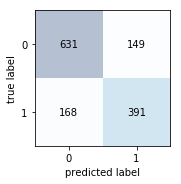

In [55]:
matrizConfusion(y_test, predsABCGS)

In [56]:
m = matrizConfusionValores(y_test, predsABCGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 631
Verdaderos Positivos: 391
Falsos Positivos: 149
Falsos Negativos: 168


Accuracy: 76.32561613144138
Misclassification error: -23.674383868558625
True Positive Rate/Recall/Sensitivity: 69.94633273703042
False Positive Rate: 19.102564102564102
Precision: 72.4074074074074
Specificity: 80.8974358974359
F1 score: 71.15559599636033


## Random Forest

In [ ]:
# RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1,
#                        min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0,
#                        min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
#                        warm_start=False, class_weight=None)

RandomizedSearchCV

In [57]:
parametrosRFRS = {'max_depth': range(20, 100), 'n_estimators': range(50, 200)}

RF = RandomForestClassifier()
RFRS = RandomizedSearchCV(RF, param_distributions = parametrosRFRS, cv = 10)

RFRS.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': range(20, 100), 'n_estimators': range(50, 200)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [58]:
print('Valor óptimo para max_depth: {}'.format(RFRS.best_params_['max_depth']))
print('Valor óptimo para n_estimators: {}'.format(RFRS.best_params_['n_estimators']))

Valor óptimo para max_depth: 58
Valor óptimo para n_estimators: 191


In [59]:
RFRSBest = RandomForestClassifier(max_depth=RFRS.best_params_['max_depth'], 
                                       n_estimators=RFRS.best_params_['n_estimators'])
RFRSBest.fit(X_train, y_train)

predsRFRSBest = RFRSBest.predict(X_test)

accuracyRFRS = np.true_divide(np.sum(predsRFRSBest == y_test), predsRFRSBest.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyRFRS))

Precisión en el conjunto de test: 75.95%


GridSearchCV

In [60]:
parametrosRFGS = {'max_depth': [26, 50, 58], 'n_estimators': [150, 191, 194, 200]}
RFGS = GridSearchCV(RandomForestClassifier(), param_grid=parametrosRFGS, cv=10)
RFGS.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [26, 50, 58], 'n_estimators': [150, 191, 194, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
means = RFGS.cv_results_['mean_test_score']
stds = RFGS.cv_results_['std_test_score']
params = RFGS.cv_results_['params']
ranks = RFGS.cv_results_['rank_test_score']

In [62]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

5) Precisión media: 77.10 +/- 2.75 con parámetros {'max_depth': 26, 'n_estimators': 150}
6) Precisión media: 77.03 +/- 2.59 con parámetros {'max_depth': 26, 'n_estimators': 191}
4) Precisión media: 77.21 +/- 2.65 con parámetros {'max_depth': 26, 'n_estimators': 194}
9) Precisión media: 76.69 +/- 2.98 con parámetros {'max_depth': 26, 'n_estimators': 200}
2) Precisión media: 77.33 +/- 2.76 con parámetros {'max_depth': 50, 'n_estimators': 150}
8) Precisión media: 76.80 +/- 2.95 con parámetros {'max_depth': 50, 'n_estimators': 191}
2) Precisión media: 77.33 +/- 2.40 con parámetros {'max_depth': 50, 'n_estimators': 194}
1) Precisión media: 77.66 +/- 2.58 con parámetros {'max_depth': 50, 'n_estimators': 200}
11) Precisión media: 76.54 +/- 3.33 con parámetros {'max_depth': 58, 'n_estimators': 150}
6) Precisión media: 77.03 +/- 2.69 con parámetros {'max_depth': 58, 'n_estimators': 191}
10) Precisión media: 76.62 +/- 2.83 con parámetros {'max_depth': 58, 'n_estimators': 194}
12) Precisión media

In [63]:
print('Valor óptimo para max_depth: {}'.format(RFGS.best_params_['max_depth']))
print('Valor óptimo para n_estimators: {}'.format(RFGS.best_params_['n_estimators']))

Valor óptimo para max_depth: 50
Valor óptimo para n_estimators: 200


In [64]:
RFGSBest = RandomForestClassifier(max_depth=RFGS.best_params_['max_depth'],
                                  n_estimators=RFGS.best_params_['n_estimators'])
RFGSBest.fit(X_train, y_train)

predsRFGS = RFGSBest.predict(X_test)

accuracyRFGS = np.true_divide(np.sum(predsRFGS == y_test), predsRFGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyRFGS))

Precisión en el conjunto de test: 75.65%


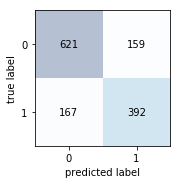

In [65]:
matrizConfusion(y_test, predsRFGS)

In [66]:
m = matrizConfusionValores(y_test, predsRFGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 621
Verdaderos Positivos: 392
Falsos Positivos: 159
Falsos Negativos: 167


Accuracy: 75.65347274085138
Misclassification error: -24.34652725914862
True Positive Rate/Recall/Sensitivity: 70.12522361359571
False Positive Rate: 20.384615384615383
Precision: 71.14337568058076
Specificity: 79.61538461538463
F1 score: 70.63063063063063


## Bayesiano

In [ ]:
# sklearn.naive_bayes.GaussianNB(priors=None, var_smoothing=1e-09)

RandomizedSearchCV

In [67]:
parametrosGNBRS = {'var_smoothing': uniform(1e-10, 1e-08, 200)}
GNB = GaussianNB()

GNBRS = RandomizedSearchCV(GNB, param_distributions = parametrosGNBRS, cv = 10)

GNBRS.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GaussianNB(priors=None, var_smoothing=1e-09),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'var_smoothing': array([3.13397e-09, 4.28698e-09, ..., 9.75403e-09, 8.87413e-09])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [68]:
print('Valor óptimo para var_smoothing: {}'.format(GNBRS.best_params_['var_smoothing']))

Valor óptimo para var_smoothing: 8.779360522019534e-09


In [69]:
GNBRSBest = GaussianNB(var_smoothing=GNBRS.best_params_['var_smoothing'])
GNBRSBest.fit(X_train, y_train)

predsGNBRS = GNBRSBest.predict(X_test)

accuracyGNBRS = np.true_divide(np.sum(predsGNBRS == y_test), predsGNBRS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyGNBRS))

Precisión en el conjunto de test: 60.34%


GridSearchCV

In [70]:
parametrosGNBGS = {'var_smoothing': [10e-10, 9.81e-9, 6.37e-10]}
GNBGS = GridSearchCV(GaussianNB(), param_grid=parametrosGNBGS, cv=10)
GNBGS.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GaussianNB(priors=None, var_smoothing=1e-09),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'var_smoothing': [1e-09, 9.81e-09, 6.37e-10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
means = GNBGS.cv_results_['mean_test_score']
stds = GNBGS.cv_results_['std_test_score']
params = GNBGS.cv_results_['params']
ranks = GNBGS.cv_results_['rank_test_score']

In [72]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

2) Precisión media: 58.16 +/- 2.03 con parámetros {'var_smoothing': 1e-09}
1) Precisión media: 58.24 +/- 2.01 con parámetros {'var_smoothing': 9.81e-09}
2) Precisión media: 58.16 +/- 2.03 con parámetros {'var_smoothing': 6.37e-10}


In [73]:
print('Valor óptimo para var_smoothing: {}'.format(GNBGS.best_params_['var_smoothing']))

Valor óptimo para var_smoothing: 9.81e-09


In [74]:
print('Valor óptimo para var_smoothing: {}'.format(GNBGS.best_params_['var_smoothing']))
GNBGSBest = GaussianNB(var_smoothing=GNBGS.best_params_['var_smoothing'])
GNBGSBest.fit(X_train, y_train)

predsGNBGS = GNBGSBest.predict(X_test)

accuracyGNBGS = np.true_divide(np.sum(predsGNBGS == y_test), predsGNBGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyGNBGS))

Valor óptimo para var_smoothing: 9.81e-09
Precisión en el conjunto de test: 60.34%


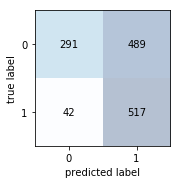

In [75]:
matrizConfusion(y_test, predsGNBGS)

In [76]:
m = matrizConfusionValores(y_test, predsGNBGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 291
Verdaderos Positivos: 517
Falsos Positivos: 489
Falsos Negativos: 42


Accuracy: 60.34353995519044
Misclassification error: -39.65646004480956
True Positive Rate/Recall/Sensitivity: 92.4865831842576
False Positive Rate: 62.69230769230769
Precision: 51.39165009940358
Specificity: 37.30769230769231
F1 score: 66.07028753993609


## Logistic Regression

In [ ]:
# LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None,
#                    random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False,
#                    n_jobs=None, l1_ratio=None)

RandomizedSearchCV

In [78]:
parametrosLGRS = {'penalty': ['l1', 'l2'], 'C': uniform(0, 2, 5)}
LG = LogisticRegression(solver='warn')

LGRS = RandomizedSearchCV(LG, param_distributions = parametrosLGRS, cv = 10)

LGRS.fit(X_train, y_train)
# lbfgs

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'penalty': ['l1', 'l2'], 'C': array([0.76576, 0.90689, 0.89954, 1.04247, 1.14727])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [84]:
print('Valor óptimo para penalty: {}'.format(LGRS.best_params_['penalty']))
print('Valor óptimo para C: {}'.format(LGRS.best_params_['C']))

Valor óptimo para penalty: l1
Valor óptimo para C: 0.7657554640864559


In [85]:
LGRSBest = LogisticRegression(penalty=LGRS.best_params_['penalty'], C=LGRS.best_params_['C'])
LGRSBest.fit(X_train, y_train)

predsLGRS = LGRSBest.predict(X_test)

accuracyLGRS = np.true_divide(np.sum(predsLGRS == y_test), predsLGRS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyLGRS))

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precisión en el conjunto de test: 71.92%


GridSearchCV

In [86]:
parametrosLGGS = {'penalty': ['l1', 'l2'], 'C': [0.16, 0.29, 1]}
LGGS = GridSearchCV(LogisticRegression(), param_grid=parametrosLGGS, cv=10)
LGGS.fit(X_train, y_train)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver 

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.16, 0.29, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [88]:
means = LGGS.cv_results_['mean_test_score']
stds = LGGS.cv_results_['std_test_score']
params = LGGS.cv_results_['params']
ranks = LGGS.cv_results_['rank_test_score']

In [89]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

1) Precisión media: 76.24 +/- 2.86 con parámetros {'C': 0.16, 'penalty': 'l1'}
3) Precisión media: 73.07 +/- 2.33 con parámetros {'C': 0.16, 'penalty': 'l2'}
2) Precisión media: 75.05 +/- 2.86 con parámetros {'C': 0.29, 'penalty': 'l1'}
5) Precisión media: 72.62 +/- 2.61 con parámetros {'C': 0.29, 'penalty': 'l2'}
4) Precisión media: 72.66 +/- 2.00 con parámetros {'C': 1, 'penalty': 'l1'}
6) Precisión media: 72.21 +/- 2.41 con parámetros {'C': 1, 'penalty': 'l2'}


In [90]:
print('Valor óptimo para penalty: {}'.format(LGGS.best_params_['penalty']))
print('Valor óptimo para C: {}'.format(LGGS.best_params_['C']))

Valor óptimo para penalty: l1
Valor óptimo para C: 0.16


In [91]:
LGGSBest = LogisticRegression(penalty=LGGS.best_params_['penalty'], C=LGGS.best_params_['C'])
LGGSBest.fit(X_train, y_train)

predsLGGS = LGGSBest.predict(X_test)

accuracyLGGS = np.true_divide(np.sum(predsLGGS == y_test), predsLGGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyLGGS))

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precisión en el conjunto de test: 73.41%


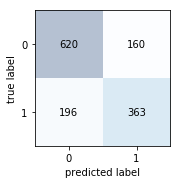

In [92]:
matrizConfusion(y_test, predsLGGS)

In [93]:
m = matrizConfusionValores(y_test, predsLGGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 620
Verdaderos Positivos: 363
Falsos Positivos: 160
Falsos Negativos: 196


Accuracy: 73.41299477221807
Misclassification error: -26.587005227781923
True Positive Rate/Recall/Sensitivity: 64.93738819320215
False Positive Rate: 20.51282051282051
Precision: 69.40726577437859
Specificity: 79.48717948717949
F1 score: 67.09796672828097


## KNN

In [ ]:
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’,
#                      metric_params=None, n_jobs=None, **kwargs

GridSearchCV

In [94]:
parametrosKNNGS = {'n_neighbors': range(5,9), 'weights': ['uniform', 'distance']}
KNNGS = GridSearchCV(KNeighborsClassifier(), param_grid=parametrosKNNGS, cv=10)
KNNGS.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 9), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [95]:
means = KNNGS.cv_results_['mean_test_score']
stds = KNNGS.cv_results_['std_test_score']
params = KNNGS.cv_results_['params']
ranks = KNNGS.cv_results_['rank_test_score']

In [96]:
for rank, mean, std, pms in zip(ranks, means, stds, params):
    print('{}) Precisión media: {:.2f} +/- {:.2f} con parámetros {}'.format(rank, mean*100, std*100, pms))

6) Precisión media: 66.42 +/- 2.90 con parámetros {'n_neighbors': 5, 'weights': 'uniform'}
7) Precisión media: 66.34 +/- 2.96 con parámetros {'n_neighbors': 5, 'weights': 'distance'}
8) Precisión media: 65.75 +/- 2.32 con parámetros {'n_neighbors': 6, 'weights': 'uniform'}
3) Precisión media: 67.05 +/- 2.46 con parámetros {'n_neighbors': 6, 'weights': 'distance'}
4) Precisión media: 66.64 +/- 2.53 con parámetros {'n_neighbors': 7, 'weights': 'uniform'}
5) Precisión media: 66.60 +/- 2.60 con parámetros {'n_neighbors': 7, 'weights': 'distance'}
2) Precisión media: 67.16 +/- 2.17 con parámetros {'n_neighbors': 8, 'weights': 'uniform'}
1) Precisión media: 67.61 +/- 2.39 con parámetros {'n_neighbors': 8, 'weights': 'distance'}


In [97]:
print('Valor óptimo para k: {}'.format(KNNGS.best_params_['n_neighbors']))
print('Valor óptimo para weights: {}'.format(KNNGS.best_params_['weights']))

Valor óptimo para k: 8
Valor óptimo para weights: distance


In [98]:
KNNGSBest = KNeighborsClassifier(n_neighbors=KNNGS.best_params_['n_neighbors'], weights=KNNGS.best_params_['weights'])
KNNGSBest.fit(X_train, y_train)

predsKNNGS = KNNGSBest.predict(X_test)

accuracyKNNGS = np.true_divide(np.sum(predsKNNGS == y_test), predsKNNGS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracyKNNGS))

Precisión en el conjunto de test: 67.06%


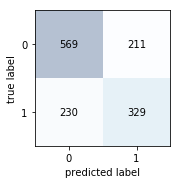

In [99]:
matrizConfusion(y_test, predsKNNGS)

In [100]:
m = matrizConfusionValores(y_test, predsKNNGS)
print('Verdaderos Negativos: {}'.format(m[0]))
print('Verdaderos Positivos: {}'.format(m[1]))
print('Falsos Positivos: {}'.format(m[2]))
print('Falsos Negativos: {}'.format(m[3]))
print("""
""")
metricas(m)

Verdaderos Negativos: 569
Verdaderos Positivos: 329
Falsos Positivos: 211
Falsos Negativos: 230


Accuracy: 67.06497386109037
Misclassification error: -32.93502613890963
True Positive Rate/Recall/Sensitivity: 58.85509838998211
False Positive Rate: 27.05128205128205
Precision: 60.92592592592593
Specificity: 72.94871794871796
F1 score: 59.87261146496815
